In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint

pd.set_option('display.max_columns', None) # Parámetro que nos permite observar en su totalidad el dataset

## Caso de Uso


---


Modelo para predecir uso de la nicotina basado en características personales y uso del alcohol.


Para conocer más acerca del dataset usado, consultarlo en la página de Kaggle:
https://www.kaggle.com/datasets/mexwell/drug-consumption-classification/data

In [29]:
df = pd.read_csv('/content/drug_consumption.csv')
print('Tamaño del dataset:', df.shape)
print(list(df.columns))
df.sample(5)

Tamaño del dataset: (1885, 32)
['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']


,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
1344,1348,-0.95197,-0.48246,0.45468,-0.57009,-0.31685,0.73545,-1.76250,0.88309,-0.45321,-2.04506,-0.21712,0.40148,CL5,CL3,CL0,CL2,CL4,CL4,CL6,CL3,CL0,CL4,CL0,CL0,CL3,CL3,CL3,CL0,CL3,CL0,CL0
110,111,1.09449,-0.48246,1.16365,0.96082,-0.50212,-0.14882,0.32197,0.14143,-0.30172,-0.14277,0.19268,-0.52593,CL5,CL0,CL0,CL0,CL6,CL0,CL6,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0
1789,1793,-0.95197,-0.48246,0.45468,-0.57009,-0.31685,0.62967,-1.50796,1.88511,-0.60633,3.00537,0.19268,1.22470,CL6,CL3,CL0,CL0,CL4,CL6,CL4,CL0,CL2,CL0,CL0,CL2,CL3,CL3,CL4,CL4,CL4,CL0,CL0
1232,1236,1.82213,-0.48246,1.16365,-0.57009,-0.31685,0.13606,0.63779,0.58331,-0.30172,0.58489,-0.21712,-0.84637,CL5,CL1,CL1,CL3,CL6,CL1,CL6,CL1,CL0,CL1,CL0,CL0,CL0,CL1,CL0,CL1,CL1,CL0,CL1
144,145,1.09449,-0.48246,-0.05921,0.24923,-0.31685,0.13606,-1.09207,-0.45174,-1.21213,-0.00665,-0.21712,0.76540,CL6,CL0,CL0,CL0,CL6,CL3,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL1,CL1,CL0,CL1


### Preparación de datos

In [30]:
# Implementación de funciones
def replace_clx(value):
    '''Función para limpiar la cadena de texto CL
    dentro de las variables categóricas del dataset'''
    if value.startswith('CL'):
        return int(value[2:])
    else:
        return value
# CL0	Never Used
# CL1	Used over a Decade Ago
# CL2	Used in Last Decade
# CL3	Used in Last Year
# CL4	Used in Last Month
# CL5	Used in Last Week
# CL6	Used in Last Day
df['Nicotine'] = df['Nicotine'].apply(replace_clx)
df['Alcohol'] = df['Alcohol'].apply(replace_clx)

df.sample()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
838,842,-0.07854,-0.48246,0.45468,-0.57009,-0.31685,0.22393,-1.37639,0.58331,-2.78793,-0.00665,0.88113,1.2247,5,CL6,CL2,CL5,CL6,CL5,CL5,CL3,CL2,CL3,CL3,CL2,CL3,CL3,CL6,CL3,6,CL0,CL2


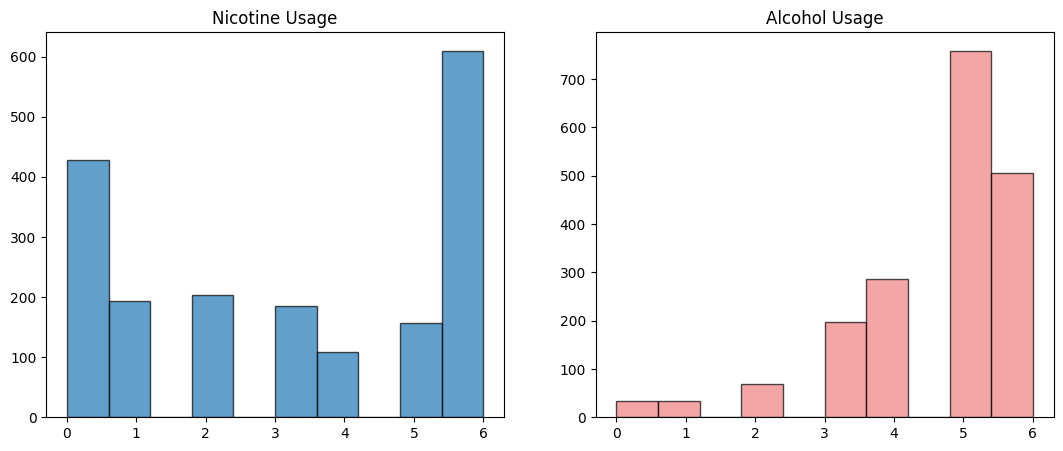

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

axs[0].hist(df['Nicotine'], bins=10, edgecolor='k', alpha=0.7, label='Nicotine Usage')
axs[0].set_title('Nicotine Usage')

axs[1].hist(df['Alcohol'], bins=10, edgecolor='k', alpha=0.7, label='Alcohol Usage', color='lightcoral')
axs[1].set_title('Alcohol Usage')

plt.show()

Para efectos del ejercicio, se agruparán todas las categorías en únicamente 2 valores:


*   0 --> Categorías 0, 1, 2
*   1 --> Categorías 3, 4, 5, 6

In [36]:
def replace_s(value):
  if value <= 2:
    return 0
  else:
    return 1
df['Nicotine'] = df['Nicotine'].apply(replace_s)

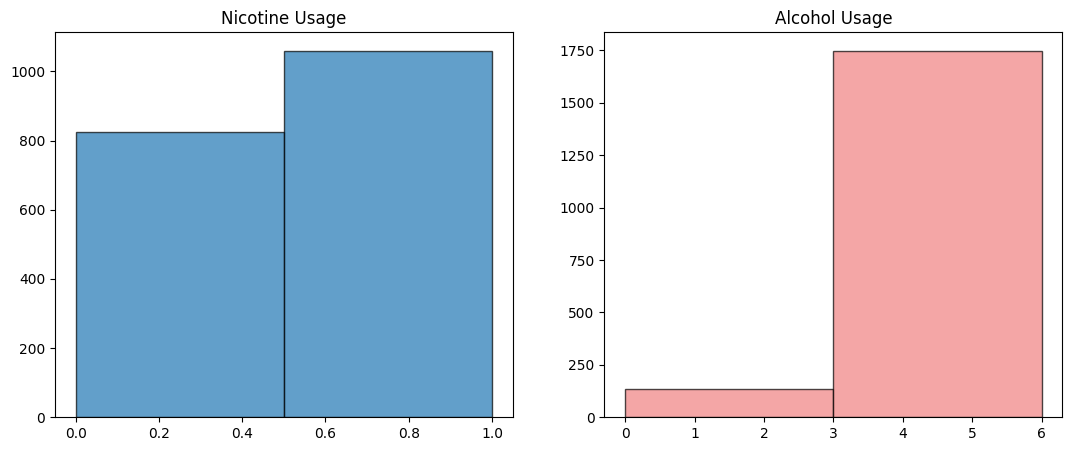

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

axs[0].hist(df['Nicotine'], bins=2, edgecolor='k', alpha=0.7, label='Nicotine Usage')
axs[0].set_title('Nicotine Usage')

axs[1].hist(df['Alcohol'], bins=2, edgecolor='k', alpha=0.7, label='Alcohol Usage', color='lightcoral')
axs[1].set_title('Alcohol Usage')

plt.show()

***Importante: Para efectos del ejercicio, se tomará el dataset transformado. Para obtener resultados más precisos y evitar sesgos en las predicciones, se deben balancear los datos, es decir, tener la misma cantidad de datos entre una categoría y otra.***

### Entrenamiento del modelo de Machine Learning: Random Forest

In [39]:
# 1. Elegimos nuetras variables que pasan al entrenamiento del modelo (denominadas como características o features)
features = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore',
            'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol']
X = df[features]
# 2. Elegimos nuestra variable que queremos predecir (denominada como objetivo o target)
y = df['Nicotine']

In [40]:
# 3. Dividimos nuestro dataset en dos, uno para entrenamiento y otro para pruebas. Lo usual es dividirlos en 80% entrenamiento y 20% pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')

X_train shape: (1508, 13)
X_test shape: (377, 13)


In [42]:
# 4. Generamos nuestra variable con el modelo que vamos a utilizar y entrenamos con nuestro dataset de entrenamiento.
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [44]:
# 5. Generamos la predicción sobre nuestros datos de prueba
y_pred = rf.predict(X_test)

In [45]:
# 6. Validamos el accuracy de nuestro modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6763925729442971


In [57]:
# 7. Entrenamos nuestro modelo a partir de hiperparámetros
param_dist = {'n_estimators': [20, 50, 100, 150, 200],
              'max_depth': [1, 3, 5, 10]}

rf2 = RandomForestClassifier(random_state=42)

rand_search = RandomizedSearchCV(rf2,
                                 param_distributions = param_dist,
                                 n_iter=20)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=20,
                   param_distributions={'max_depth': [1, 3, 5, 10],
                                        'n_estimators': [20, 50, 100, 150,
                                                         200]})

In [58]:
# 8. Nos quedamos con el mejor modelo generado
best_rf = rand_search.best_estimator_

In [59]:
# 9. Validamos nuestro modelo
y_pred2 = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}')

Accuracy: 0.6790450928381963
Precision: 0.6775510204081633
Recall: 0.7980769230769231


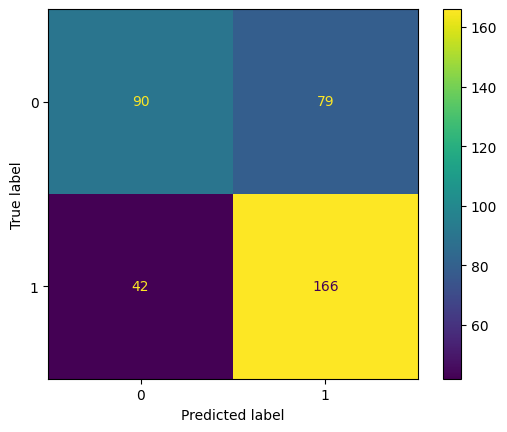

In [60]:
# 10. Nos auxiliamos de gráficos adicionales para la validación del modelo
cm = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

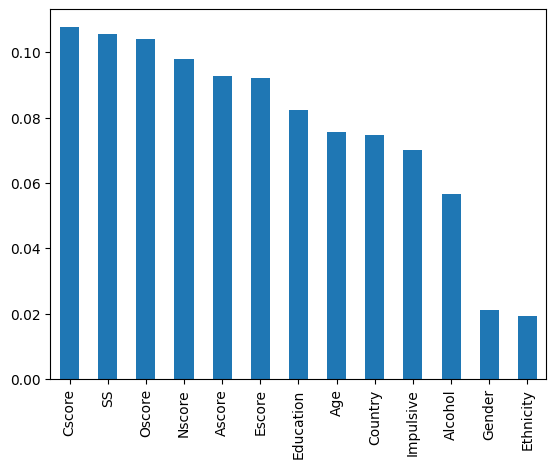

In [ ]:
# 11. OPCIONAL - Mediante el siguiente código, podemos observar las características más importantes ocupadas en el entrenamiento del modelo
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar();